# **Import Library**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import shutil
import random
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pathlib import Path

# **Setup Paths dan Parameters**

In [2]:
# Path dataset
BASE_DIR = Path(r"D:\Perkuliahan\Asah led by Dicoding\Asah_Proyek Klasifikasi Gambar")
DATASET_SOURCE = BASE_DIR / "Dataset" / "lung_image_sets"
DATASET_SPLIT = BASE_DIR / "Dataset" / "split_dataset"

# Path output
SAVED_MODEL_DIR = BASE_DIR / "saved_model"
TFJS_MODEL_DIR = BASE_DIR / "tfjs_model"
TFLITE_MODEL_DIR = BASE_DIR / "tflite"

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15
RANDOM_SEED = 42

# Class names
CLASS_NAMES = ['lung_aca', 'lung_n', 'lung_scc']
CLASS_LABELS = {
    'lung_aca': 'Lung Adenocarcinoma',
    'lung_n': 'Lung Benign Tissue',
    'lung_scc': 'Lung Squamous Cell Carcinoma'
}

# Set random seed
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# **Split Dataset (Train/Validation/Test)**

In [3]:
def split_dataset(source_dir, output_dir, val_split=0.15, test_split=0.15, seed=42):
    random.seed(seed)
    
    # Create directories
    for split in ['train', 'validation', 'test']:
        for class_name in CLASS_NAMES:
            os.makedirs(output_dir / split / class_name, exist_ok=True)
    
    # Process each class
    for class_name in CLASS_NAMES:
        class_path = source_dir / class_name
        images = list(class_path.glob('*.jpeg')) + list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))
        
        # Shuffle
        random.shuffle(images)
        
        # Calculate splits
        total = len(images)
        test_size = int(total * test_split)
        val_size = int(total * val_split)
        train_size = total - test_size - val_size
        
        # Split
        train_images = images[:train_size]
        val_images = images[train_size:train_size + val_size]
        test_images = images[train_size + val_size:]
        
        print(f"\n{class_name}:")
        print(f"  Total: {total}")
        print(f"  Train: {len(train_images)}")
        print(f"  Validation: {len(val_images)}")
        print(f"  Test: {len(test_images)}")
        
        # Copy files
        for img in train_images:
            shutil.copy2(img, output_dir / 'train' / class_name / img.name)
        for img in val_images:
            shutil.copy2(img, output_dir / 'validation' / class_name / img.name)
        for img in test_images:
            shutil.copy2(img, output_dir / 'test' / class_name / img.name)

# Split dataset jika belum ada
if not DATASET_SPLIT.exists():
    print("Splitting dataset...")
    split_dataset(DATASET_SOURCE, DATASET_SPLIT, VALIDATION_SPLIT, TEST_SPLIT, RANDOM_SEED)
    print("\nDataset split completed!")
else:
    print("Split dataset already exists. Skipping split process.")

Splitting dataset...

lung_aca:
  Total: 5000
  Train: 3500
  Validation: 750
  Test: 750

lung_n:
  Total: 5000
  Train: 3500
  Validation: 750
  Test: 750

lung_scc:
  Total: 5000
  Train: 3500
  Validation: 750
  Test: 750

Dataset split completed!


# **Data Augmentation & Generators**

In [4]:
# Data Augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescale untuk validation dan test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    DATASET_SPLIT / 'train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED
)

validation_generator = val_test_datagen.flow_from_directory(
    DATASET_SPLIT / 'validation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    DATASET_SPLIT / 'test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nTrain samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"\nClass indices: {train_generator.class_indices}")

Found 10500 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.

Train samples: 10500
Validation samples: 2250
Test samples: 2250

Class indices: {'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2}


# **Visualisasi Preprocessing & Augmentasi Data**


Visualisasi Preprocessing dan Augmentasi Data:


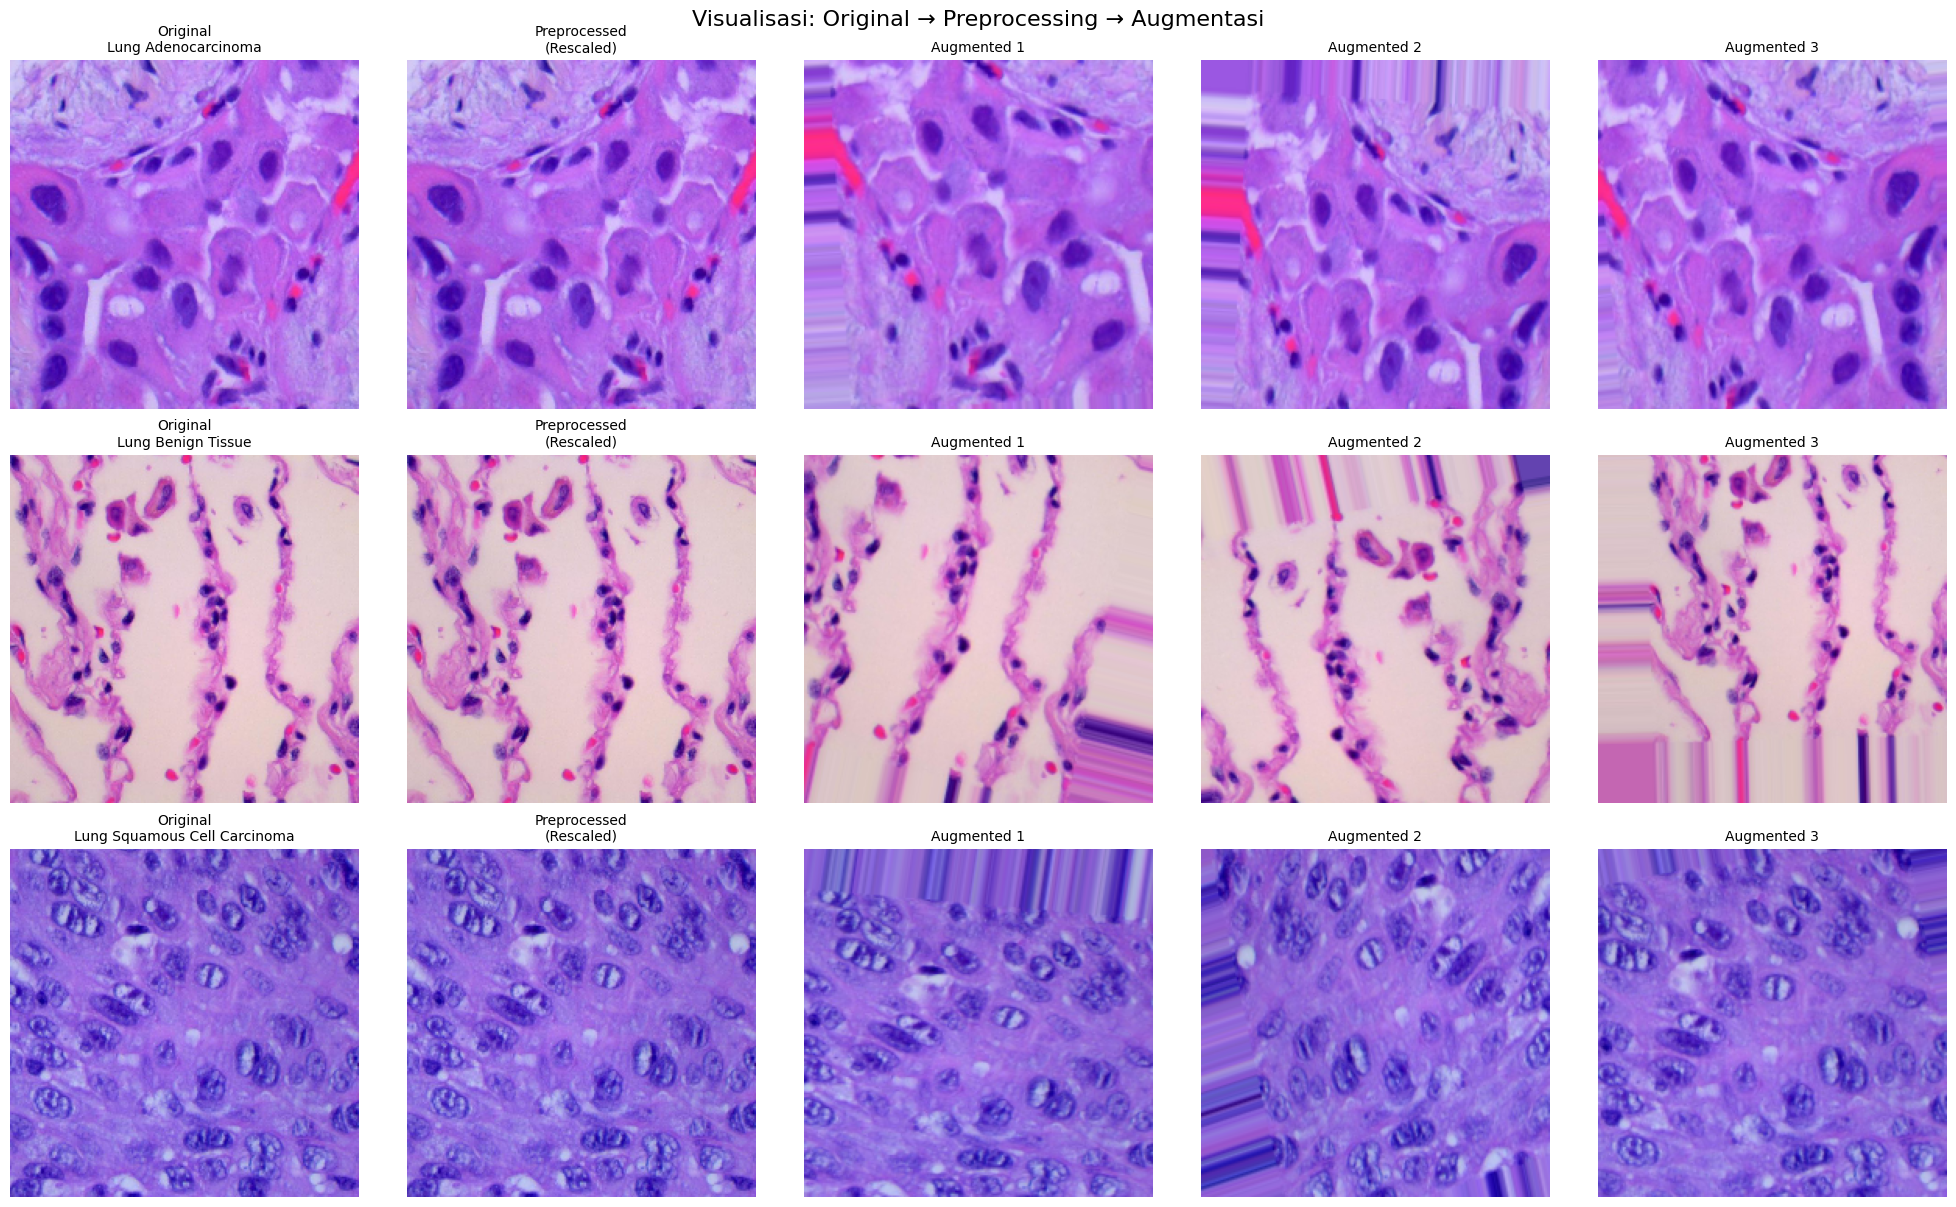

In [5]:
def plot_preprocessing_and_augmentation():

    # Ambil satu sample image dari setiap class
    fig, axes = plt.subplots(len(CLASS_NAMES), 5, figsize=(20, 4*len(CLASS_NAMES)))
    
    for class_idx, class_name in enumerate(CLASS_NAMES):
        # Get image path
        class_path = DATASET_SOURCE / class_name
        original_images = list(class_path.glob('*.jpeg')) + list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))
        
        if original_images:
            img_path = original_images[0]
            
            # Load original image
            img_original = image.load_img(img_path, target_size=IMG_SIZE)
            img_array = image.img_to_array(img_original)
            
            # Plot original
            axes[class_idx, 0].imshow(img_array.astype('uint8'))
            axes[class_idx, 0].set_title(f'Original\n{CLASS_LABELS[class_name]}', fontsize=10)
            axes[class_idx, 0].axis('off')
            
            # Plot preprocessed
            img_rescaled = img_array / 255.0
            axes[class_idx, 1].imshow(img_rescaled)
            axes[class_idx, 1].set_title(f'Preprocessed\n(Rescaled)', fontsize=10)
            axes[class_idx, 1].axis('off')
            
            # Plot 3 augmented versions
            img_expanded = np.expand_dims(img_array, axis=0)
            aug_count = 0
            for batch in train_datagen.flow(img_expanded, batch_size=1):
                if aug_count >= 3:
                    break
                axes[class_idx, 2 + aug_count].imshow(batch[0])
                axes[class_idx, 2 + aug_count].set_title(f'Augmented {aug_count + 1}', fontsize=10)
                axes[class_idx, 2 + aug_count].axis('off')
                aug_count += 1
    
    plt.tight_layout()
    plt.suptitle('Visualisasi: Original → Preprocessing → Augmentasi', fontsize=16, y=1.002)
    plt.show()

print("\nVisualisasi Preprocessing dan Augmentasi Data:")
plot_preprocessing_and_augmentation()

# **Model Architecture VGG16**

In [ ]:
def create_vgg16_model(input_shape=(224, 224, 3), num_classes=3):
  
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze ALL base model layers
    base_model.trainable = False
 
    model = models.Sequential([
        base_model,
        # Conv2D dan Pooling Layer
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # Flatten dan Dense layers
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ], name='VGG16_TransferLearning_Optimized')
    
    return model

# Create VGG16 model
vgg16_model = create_vgg16_model(input_shape=(*IMG_SIZE, 3), num_classes=len(CLASS_NAMES))
vgg16_model.summary()

Model: "VGG16_TransferLearning_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

# **Training Function**

In [7]:
def train_model(model, model_name, train_gen, val_gen, epochs=15):

    # Compile model 
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    checkpoint_path = f'best_{model_name}.keras'
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=7,  
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            checkpoint_path,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # Training
    print(f"\nTraining {model_name}...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

# **Training VGG16 Model**

In [8]:
history_vgg16 = train_model(
    vgg16_model,
    'vgg16',
    train_generator,
    validation_generator,
    epochs=EPOCHS
)


Training vgg16...
Epoch 1/15


d:\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8608 - loss: 0.3436
Epoch 1: val_accuracy improved from -inf to 0.95422, saving model to best_vgg16.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 1122s 3s/step - accuracy: 0.8609 - loss: 0.3433 - val_accuracy: 0.9542 - val_loss: 0.1168 - learning_rate: 0.0010
Epoch 2/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9289 - loss: 0.1789
Epoch 2: val_accuracy did not improve from 0.95422
329/329 ━━━━━━━━━━━━━━━━━━━━ 1101s 3s/step - accuracy: 0.9290 - loss: 0.1789 - val_accuracy: 0.9311 - val_loss: 0.2079 - learning_rate: 0.0010
Epoch 3/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9407 - loss: 0.1477
Epoch 3: val_accuracy did not improve from 0.95422
329/329 ━━━━━━━━━━━━━━━━━━━━ 1101s 3s/step - accuracy: 0.9407 - loss: 0.1477 - val_accuracy: 0.9524 - val_loss: 0.1083 - learning_rate: 0.0010
Epoch 4/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9528 - loss: 0.1211
Epoch 4: val_accuracy improved from 0.95422 to 0.97022

# **Visualisasi Training History**


VGG16 Training History:


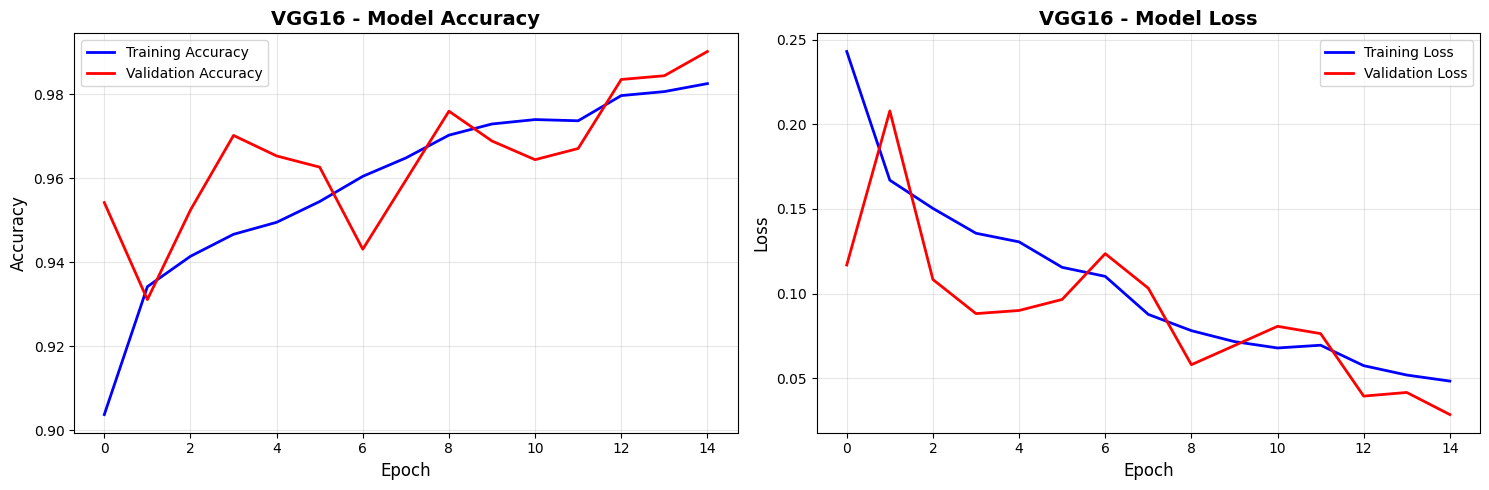


VGG16 Metrics:
  Training Accuracy: 0.9826
  Validation Accuracy: 0.9902
  Training Loss: 0.0483
  Validation Loss: 0.0285


In [9]:
def plot_training_history(history, model_name):
   
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    ax1.plot(epochs_range, acc, 'b-', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs_range, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title(f'{model_name} - Model Accuracy', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Loss
    ax2.plot(epochs_range, loss, 'b-', label='Training Loss', linewidth=2)
    ax2.plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title(f'{model_name} - Model Loss', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Final metrics
    print(f"\n{model_name} Metrics:")
    print(f"  Training Accuracy: {acc[-1]:.4f}")
    print(f"  Validation Accuracy: {val_acc[-1]:.4f}")
    print(f"  Training Loss: {loss[-1]:.4f}")
    print(f"  Validation Loss: {val_loss[-1]:.4f}")

# Plot history
print("\nVGG16 Training History:")
plot_training_history(history_vgg16, 'VGG16')

# **Evaluasi Model pada Training Set**

Found 10500 images belonging to 3 classes.
329/329 ━━━━━━━━━━━━━━━━━━━━ 893s 3s/step - accuracy: 0.9969 - loss: 0.0102

Training Loss: 0.0214
Training Accuracy: 0.9930
329/329 ━━━━━━━━━━━━━━━━━━━━ 896s 3s/step

Verifikasi alignment:
  Total samples: 10500
  Total predictions: 10500
  Match: True

Classification Report:
                              precision    recall  f1-score   support

         Lung Adenocarcinoma       0.98      1.00      0.99      3500
          Lung Benign Tissue       1.00      1.00      1.00      3500
Lung Squamous Cell Carcinoma       1.00      0.98      0.99      3500

                    accuracy                           0.99     10500
                   macro avg       0.99      0.99      0.99     10500
                weighted avg       0.99      0.99      0.99     10500



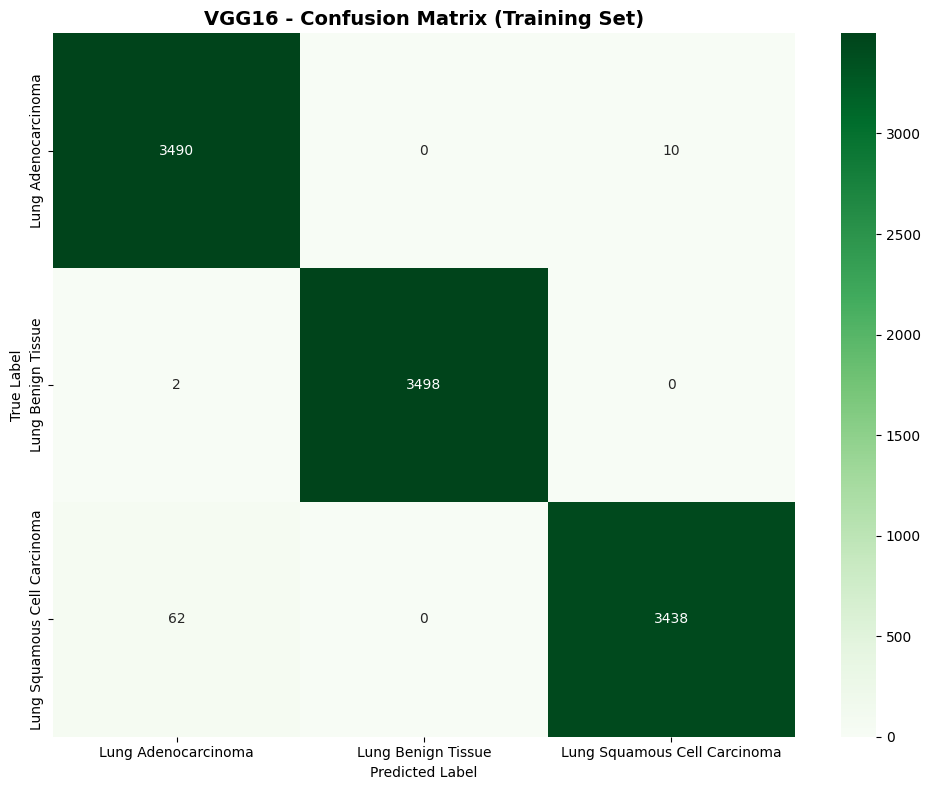

In [10]:


def evaluate_model_on_train(model, train_gen, model_name):
 
    train_eval_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        DATASET_SPLIT / 'train',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False  
    )
    
    # Evaluate
    train_loss, train_accuracy = model.evaluate(train_eval_gen, verbose=1)
    print(f"\nTraining Loss: {train_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    
    train_eval_gen.reset()
    predictions = model.predict(train_eval_gen, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = train_eval_gen.classes
    
    # Verify alignment
    print(f"\nVerifikasi alignment:")
    print(f"  Total samples: {len(y_true)}")
    print(f"  Total predictions: {len(y_pred)}")
    print(f"  Match: {len(y_true) == len(y_pred)}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=[CLASS_LABELS[name] for name in CLASS_NAMES]
    ))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Greens',
        xticklabels=[CLASS_LABELS[name] for name in CLASS_NAMES],
        yticklabels=[CLASS_LABELS[name] for name in CLASS_NAMES]
    )
    plt.title(f'{model_name} - Confusion Matrix (Training Set)', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return train_accuracy, y_pred, y_true

# Evaluate on training set
vgg16_train_accuracy, vgg16_train_pred, vgg16_train_true = evaluate_model_on_train(
    vgg16_model, train_generator, 'VGG16'
)
train_generator.reset()

# **Evaluasi Model pada Test Set**

d:\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.9945 - loss: 0.0170

Test Loss: 0.0274
Test Accuracy: 0.9916
71/71 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step

Verifikasi alignment:
  Total samples: 2250
  Total predictions: 2250
  Match: True

Classification Report:
                              precision    recall  f1-score   support

         Lung Adenocarcinoma       0.98      0.99      0.99       750
          Lung Benign Tissue       1.00      1.00      1.00       750
Lung Squamous Cell Carcinoma       0.99      0.98      0.99       750

                    accuracy                           0.99      2250
                   macro avg       0.99      0.99      0.99      2250
                weighted avg       0.99      0.99      0.99      2250



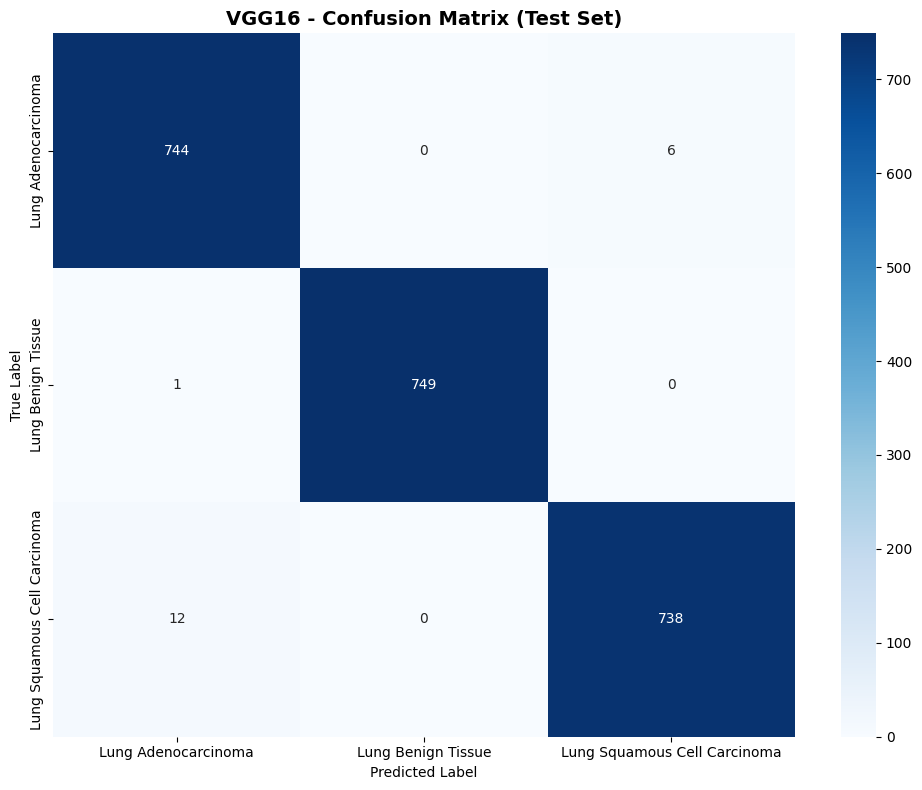

In [11]:


def evaluate_model_on_test(model, test_gen, model_name):
    
    # Evaluate
    test_gen.reset()
    test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Predictions
    test_gen.reset()
    predictions = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes
    
    # Verify alignment
    print(f"\nVerifikasi alignment:")
    print(f"  Total samples: {len(y_true)}")
    print(f"  Total predictions: {len(y_pred)}")
    print(f"  Match: {len(y_true) == len(y_pred)}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=[CLASS_LABELS[name] for name in CLASS_NAMES]
    ))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[CLASS_LABELS[name] for name in CLASS_NAMES],
        yticklabels=[CLASS_LABELS[name] for name in CLASS_NAMES]
    )
    plt.title(f'{model_name} - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return test_accuracy, y_pred, y_true

# Evaluate on test set
vgg16_test_accuracy, vgg16_test_pred, vgg16_test_true = evaluate_model_on_test(
    vgg16_model, test_generator, 'VGG16'
)
test_generator.reset()

# **Visualisasi Prediksi vs Actual**


Visualisasi Prediksi vs Actual:


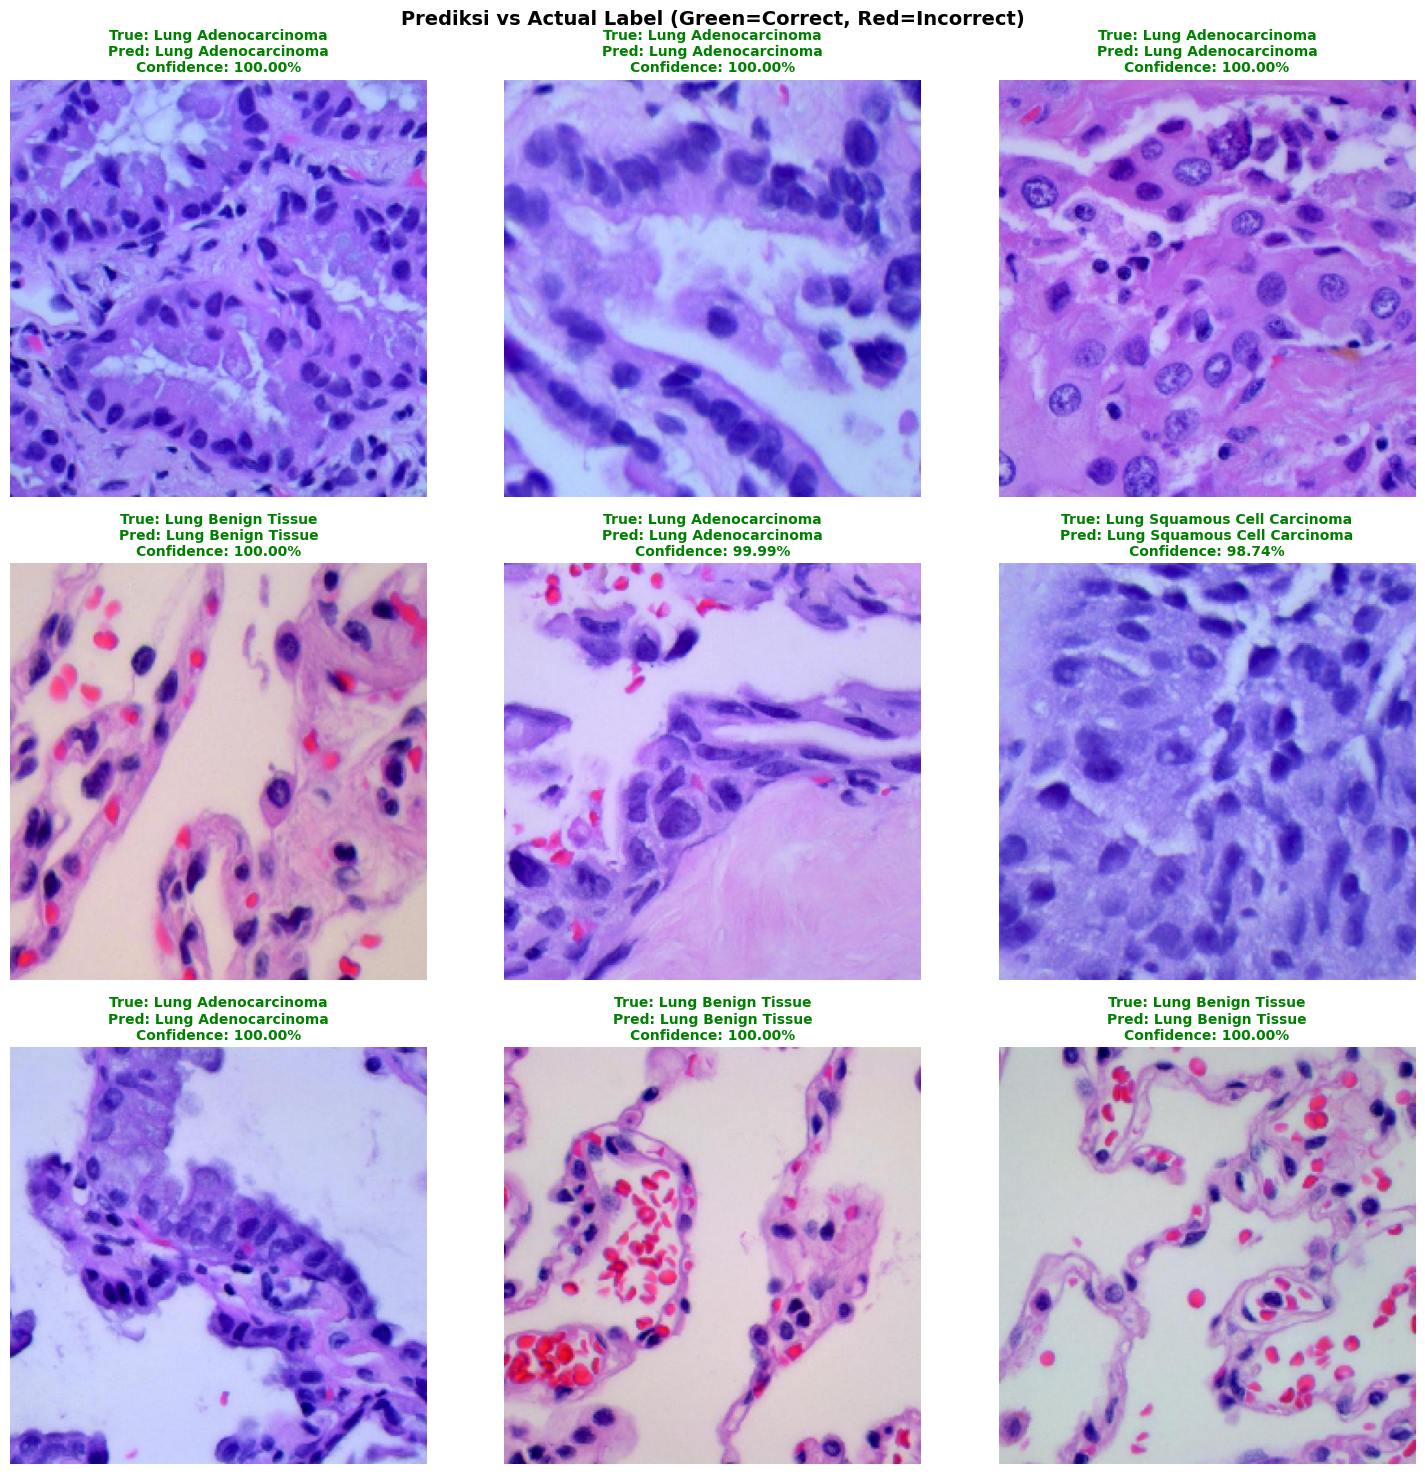

In [12]:


def plot_predictions_vs_actual(model, test_gen, num_samples=9):
   
    test_gen.reset()
    
    # Get predictions
    predictions = model.predict(test_gen, verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes
    
    # Get random samples
    indices = np.random.choice(len(y_true), num_samples, replace=False)
    
    # Plot
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        # Get image
        test_gen.reset()
        for _ in range(idx // BATCH_SIZE + 1):
            images, _ = next(test_gen)
        img = images[idx % BATCH_SIZE]
        
        # Get labels
        true_label = CLASS_LABELS[CLASS_NAMES[y_true[idx]]]
        pred_label = CLASS_LABELS[CLASS_NAMES[y_pred[idx]]]
        confidence = predictions[idx][y_pred[idx]]
        
        # Determine color
        color = 'green' if y_true[idx] == y_pred[idx] else 'red'
        
        # Plot
        axes[i].imshow(img)
        axes[i].set_title(
            f'True: {true_label}\n'
            f'Pred: {pred_label}\n'
            f'Confidence: {confidence:.2%}',
            color=color,
            fontsize=10,
            fontweight='bold'
        )
        axes[i].axis('off')
    
    plt.suptitle('Prediksi vs Actual Label (Green=Correct, Red=Incorrect)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\nVisualisasi Prediksi vs Actual:")
plot_predictions_vs_actual(vgg16_model, test_generator, num_samples=9)